In [1]:
# 구글 드라이버 이용
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [0]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

# 4319
train_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv').set_index('id')
test_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test.csv').set_index('id')

In [4]:
print(train_dt.shape)
train_dt.head(2)

(4752, 59)


,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN


### 분석 방법

1. Y00 - Y17 4300개의 데이터로 각 feature 430개의 값을 예측 
    - Y18 값과 유사한 feature 찾기
    - Y06,Y09,Y12,Y16이 Y18과의 mse값이 낮고, 상관도가 높다.

2. Y06,Y09,Y12,Y16의 조합으로 진짜 Y18을 예측
    - mse가 가장 낮은 조합을 사용

3. 2번의 조합 + 기존의 Y18로 나머지 test 예측

4. feature 공학

In [0]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [6]:
X_train = train_dt.iloc[:, :40]

X_train.head(2)

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0


In [0]:
X_train = train_dt.iloc[:4320, :40]
X_test = train_dt.iloc[4320:, :40]

In [0]:
# def func(num):
#   # -17 ~ -2 / -1 : Y18
#   print(num)

#   y_train = train_dt.iloc[:4320, 40 + num]
#   y_test = train_dt.iloc[4320:, 40 + num]

#   lgb_train = lgb.Dataset(X_train, label=y_train)

#   lgb_param = {
#       "objective":"regression",
#       "metrics":"mae",
#       "learning_rate":0.01
#   }

#   print("cv start")
#   cv_result = lgb.cv(
#       lgb_param,
#       lgb_train,
#       num_boost_round=99999,
#       nfold=5,
#       early_stopping_rounds=10,
#       stratified=False,
#       verbose_eval=10 
#   )

#   print("train start")
#   lgb_model = lgb.train(
#       lgb_param,
#       lgb_train,
#       num_boost_round=len(cv_result["l1-mean"])
#   )

#   pred = lgb_model.predict(X_test)

#   return pred

In [0]:
# main = np.array([])

# for i in range(0,18):
#   pred = func(i)
#   if i:
#     main = np.vstack([main, pred])
#   else:
#     main = np.copy(pred)
  
# main = pd.DataFrame(main)

In [0]:
# main.to_csv('/content/gdrive/My Drive/Colab Notebooks/answer.csv')

In [11]:
main = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/answer.csv')

main = main.iloc[:, 1:].T

main.shape

(432, 18)

In [0]:
Y = train_dt.iloc[4320:,-1]

Y.index = main.index

In [0]:
result = pd.concat([main, Y], axis = 1)

list_corr = result.corr().tail(1).T

In [14]:
list_mse = []
list_mean = []
for i in range(18):
  tmp = (result[i] - result['Y18'])
  list_mse.append([(tmp**2).sum()])
  list_mean.append([tmp.mean()])

pd.concat([pd.DataFrame(list_mse), pd.DataFrame(list_mean), list_corr], axis = 1)

,0,0,Y18
0,13575.717918,-3.041890,0.712467
1,5941.282800,0.623150,0.829174
2,5625.742651,0.494977,0.832368
3,14312.847654,-0.726485,0.428286
4,14449.095241,-0.603510,0.407004
5,10048.345054,1.279566,0.791205
6,3997.712553,-1.839526,0.932232
7,3788.741591,-1.463564,0.912251
8,13390.365867,1.707048,0.794422
9,3697.174401,-0.385231,0.913202


## 분석 경우의 수
1. 상관 계수 0.9이상인 변수 평균
2. mse 값이 낮은 변수 5개(4000이하)
3. 상관 계수 0.9 이상인 변수에서 평균 값을 더해 줘 mse값이 낮은 변수 선택


6,9,12,16

In [15]:
def func(data):
  return data.mean()

result_mse = {}
lst = [6,7,9,12,16]

for a in lst:
  for b in lst:
    for c in lst:
      for d in lst:
        result = 0
        main.result = main[[a,b,c,d]].apply(func, axis = 1)
        
        for i in range(len(main)):
          result += (main.result[i] - Y[i])**2

        result_mse[str(a) + '_' + str(b) + '_'+str(c)+'_'+str(d)] = result

result_mse

{'12_12_12_12': 2712.463555293624,
 '12_12_12_16': 2494.4345459503393,
 '12_12_12_6': 2820.4000323055316,
 '12_12_12_7': 2870.406738298654,
 '12_12_12_9': 2557.84993289073,
 '12_12_16_12': 2494.4345459503393,
 '12_12_16_16': 2459.8629214870766,
 '12_12_16_6': 2566.530176347333,
 '12_12_16_7': 2623.512695860149,
 '12_12_16_9': 2534.6649888542433,
 '12_12_6_12': 2820.400032305531,
 '12_12_6_16': 2566.530176347333,
 '12_12_6_6': 3070.5870242740034,
 '12_12_6_7': 3047.415596594705,
 '12_12_6_9': 2608.8547354052384,
 '12_12_7_12': 2870.4067382986545,
 '12_12_7_16': 2623.512695860149,
 '12_12_7_6': 3047.4155965947048,
 '12_12_7_7': 3102.4341385046823,
 '12_12_7_9': 2684.2648211593455,
 '12_12_9_12': 2557.8499328907305,
 '12_12_9_16': 2534.6649888542424,
 '12_12_9_6': 2608.8547354052375,
 '12_12_9_7': 2684.264821159345,
 '12_12_9_9': 2670.4305330436514,
 '12_16_12_12': 2494.4345459503393,
 '12_16_12_16': 2459.8629214870766,
 '12_16_12_6': 2566.530176347333,
 '12_16_12_7': 2623.512695860149,
 

In [17]:
pd.Series(result_mse).sort_values()[:30]

16_16_12_12    2459.862921
12_16_12_16    2459.862921
12_12_16_16    2459.862921
16_12_12_16    2459.862921
16_12_16_12    2459.862921
12_16_16_12    2459.862921
12_12_12_16    2494.434546
12_16_12_12    2494.434546
12_12_16_12    2494.434546
16_12_12_12    2494.434546
12_16_6_16     2496.117705
16_12_6_16     2496.117705
16_12_16_6     2496.117705
6_16_12_16     2496.117705
6_12_16_16     2496.117705
12_16_16_6     2496.117705
12_6_16_16     2496.117705
16_6_12_16     2496.117705
16_6_16_12     2496.117705
6_16_16_12     2496.117705
16_16_12_6     2496.117705
16_16_6_12     2496.117705
12_12_9_16     2534.664989
12_9_12_16     2534.664989
9_12_12_16     2534.664989
12_12_16_9     2534.664989
16_9_12_12     2534.664989
12_16_9_12     2534.664989
9_16_12_12     2534.664989
9_12_16_12     2534.664989
dtype: float64

In [0]:
def make_figure(row, col, n=8,m=4):
    n = 4 * col; m = 4 * row
    f, ax = plt.subplots(row, col, figsize = (n,m))
    return f, ax

In [0]:
def func(data):
  return data.mean()

In [0]:
Y = Y.reset_index()["Y18"]

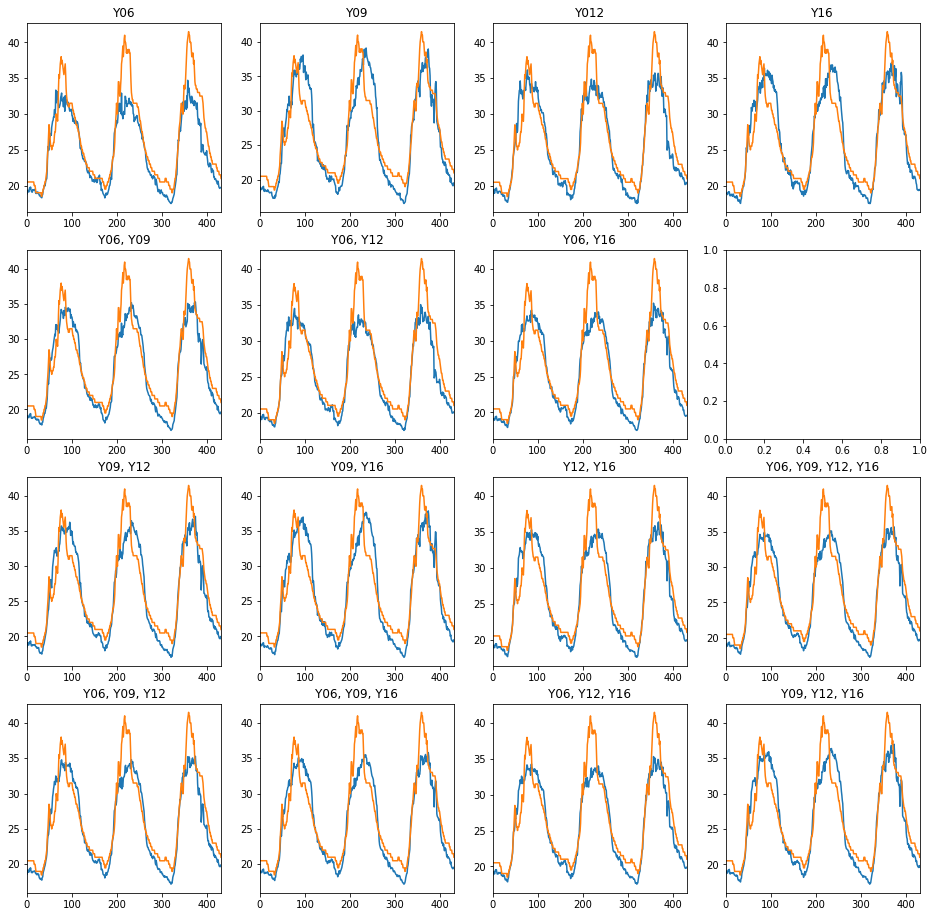

In [21]:
main_16 = main[[16]].apply(func, axis = 1)
main_12 = main[[12]].apply(func, axis = 1)
main_9 = main[[9]].apply(func, axis = 1)
main_6 = main[[6]].apply(func, axis = 1)

f, ax = make_figure(4,4)
main_6.plot(ax = ax[0][0])
ax[0][0].set_title('Y06')
Y.plot(ax = ax[0][0])

main_9.plot(ax = ax[0][1])
ax[0][1].set_title('Y09')
Y.plot(ax = ax[0][1])

main_12.plot(ax = ax[0][2])
ax[0][2].set_title('Y012')
Y.plot(ax = ax[0][2])

main_16.plot(ax = ax[0][3])
ax[0][3].set_title('Y16')
Y.plot(ax = ax[0][3])

main_6_9 = main[[6, 9]].apply(func, axis = 1)
main_6_12 = main[[6, 12]].apply(func, axis = 1)
main_6_16 = main[[6, 16]].apply(func, axis = 1)
main_9_12 = main[[9, 12]].apply(func, axis = 1)
main_9_16 = main[[9, 16]].apply(func, axis = 1)
main_12_16 = main[[12, 16]].apply(func, axis = 1)

main_6_9.plot(ax = ax[1][0])
ax[1][0].set_title('Y06, Y09')
Y.plot(ax = ax[1][0])

main_6_12.plot(ax = ax[1][1])
ax[1][1].set_title('Y06, Y12')
Y.plot(ax = ax[1][1])

main_6_16.plot(ax = ax[1][2])
ax[1][2].set_title('Y06, Y16')
Y.plot(ax = ax[1][2])

main_9_12.plot(ax = ax[2][0])
ax[2][0].set_title('Y09, Y12')
Y.plot(ax = ax[2][0])

main_9_16.plot(ax = ax[2][1])
ax[2][1].set_title('Y09, Y16')
Y.plot(ax = ax[2][1])

main_12_16.plot(ax = ax[2][2])
ax[2][2].set_title('Y12, Y16')
Y.plot(ax = ax[2][2])

main_6_9_12 = main[[6, 9, 12]].apply(func, axis = 1)
main_6_9_16 = main[[6, 9, 16]].apply(func, axis = 1)
main_6_12_16 = main[[6, 12, 16]].apply(func, axis = 1)
main_9_12_16 = main[[9, 12, 16]].apply(func, axis = 1)
main_6_9_12_16 = main[[6, 9, 12, 16]].apply(func, axis = 1)

main_6_9_12_16.plot(ax = ax[2][3])
ax[2][3].set_title('Y06, Y09, Y12, Y16')
Y.plot(ax = ax[2][3])

main_6_9_12.plot(ax = ax[3][0])
ax[3][0].set_title('Y06, Y09, Y12')
Y.plot(ax = ax[3][0])

main_6_9_16.plot(ax = ax[3][1])
ax[3][1].set_title('Y06, Y09, Y16')
Y.plot(ax = ax[3][1])

main_6_12_16.plot(ax = ax[3][2])
ax[3][2].set_title('Y06, Y12, Y16')
Y.plot(ax = ax[3][2])

main_9_12_16.plot(ax = ax[3][3])
ax[3][3].set_title('Y09, Y12, Y16')
Y.plot(ax = ax[3][3])

In [22]:
lst = [['Y06'], ['Y09'], ['Y12'], ['Y16'], ['Y06', 'Y09'], ['Y06', 'Y12'], ['Y06', 'Y16'], ['Y09', 'Y12'], ['Y09', 'Y16'], ['Y12', 'Y16'], ['Y06', 'Y09', 'Y12'], ['Y06', 'Y09', 'Y16'], ['Y06', 'Y12', 'Y16'], ['Y09', 'Y12', 'Y16'], ['Y06', 'Y09', 'Y12', 'Y16']]

for i in lst:
  print(i)

['Y06']
['Y09']
['Y12']
['Y16']
['Y06', 'Y09']
['Y06', 'Y12']
['Y06', 'Y16']
['Y09', 'Y12']
['Y09', 'Y16']
['Y12', 'Y16']
['Y06', 'Y09', 'Y12']
['Y06', 'Y09', 'Y16']
['Y06', 'Y12', 'Y16']
['Y09', 'Y12', 'Y16']
['Y06', 'Y09', 'Y12', 'Y16']


In [0]:
# def predict_Y18(lst):
#   # -17 ~ -2 / -1 : Y18
#   print(lst)
#   y_train = train_dt[lst].iloc[:-432].mean(axis = 1)
  
#   lgb_train = lgb.Dataset(X_train, label=y_train)

#   lgb_param = {
#       "objective":"regression",
#       "metrics":"mae",
#       "learning_rate":0.01
#   }

#   print("cv start")
#   cv_result = lgb.cv(
#       lgb_param,
#       lgb_train,
#       num_boost_round=99999,
#       nfold=5,
#       early_stopping_rounds=10,
#       stratified=False,
#       verbose_eval=10 
#   )

#   print("train start")
#   lgb_model = lgb.train(
#       lgb_param,
#       lgb_train,
#       num_boost_round=len(cv_result["l1-mean"])
#   )

#   pred = lgb_model.predict(X_test)

#   return pred

In [0]:
# Y_18_pred = np.array([])

# # 6,9,12,16 조합
# for i in range(len(lst)):
#   pred = predict_Y18(lst[i])
#   if i:
#     Y_18_pred = np.vstack([Y_18_pred, pred])
#   else:
#     Y_18_pred = np.copy(pred)

In [0]:
# tmp = ''
# new_lst = []

# for i in lst:
#   tmp = ''
#   for j in i:
#     tmp += j
#     tmp += ' '
#   new_lst.append(tmp)

In [26]:
# result = pd.DataFrame(Y_18_pred).T.drop([14], axis = 1)

# result.columns = new_lst

# result.head()

# result.to_csv('/content/gdrive/My Drive/Colab Notebooks/Y_18_pred.csv')

result = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Y_18_pred.csv')#.set_index('Unnamed: 0')
result.drop(['Unnamed: 0'], axis = 1, inplace = True)
result.head()

,Y06,Y09,Y12,Y16,Y06 Y09,Y06 Y12,Y06 Y16,Y09 Y12,Y09 Y16,Y12 Y16,Y06 Y09 Y12,Y06 Y09 Y16,Y06 Y12 Y16,Y09 Y12 Y16,Y06 Y09 Y12 Y16
0,18.845756,18.373625,18.620389,18.927268,18.539393,18.759013,19.094353,18.537991,18.584360,18.659948,18.770619,18.701005,18.993457,18.877019,18.859467
1,19.267054,18.937526,19.030593,18.963062,18.943739,19.148287,19.233473,18.712978,18.972454,18.882619,19.046229,18.930276,19.136025,18.903168,19.011388
2,19.349430,18.787999,19.482350,18.927107,18.912318,19.494935,19.068623,18.957221,18.914959,18.929575,19.168831,18.817017,19.294089,18.990170,19.090679
3,19.235970,18.680234,19.254379,18.953197,18.847544,19.104296,19.054984,18.789796,18.813882,18.827827,19.024236,18.804461,19.107944,18.845469,18.969609
4,19.087358,18.560923,18.963182,18.758588,18.775857,18.954931,18.927083,18.726944,18.681369,18.444284,19.010431,18.761889,18.904071,18.818516,18.910641


In [0]:
Y = Y[-432:].values

In [0]:
Y = pd.DataFrame(Y)

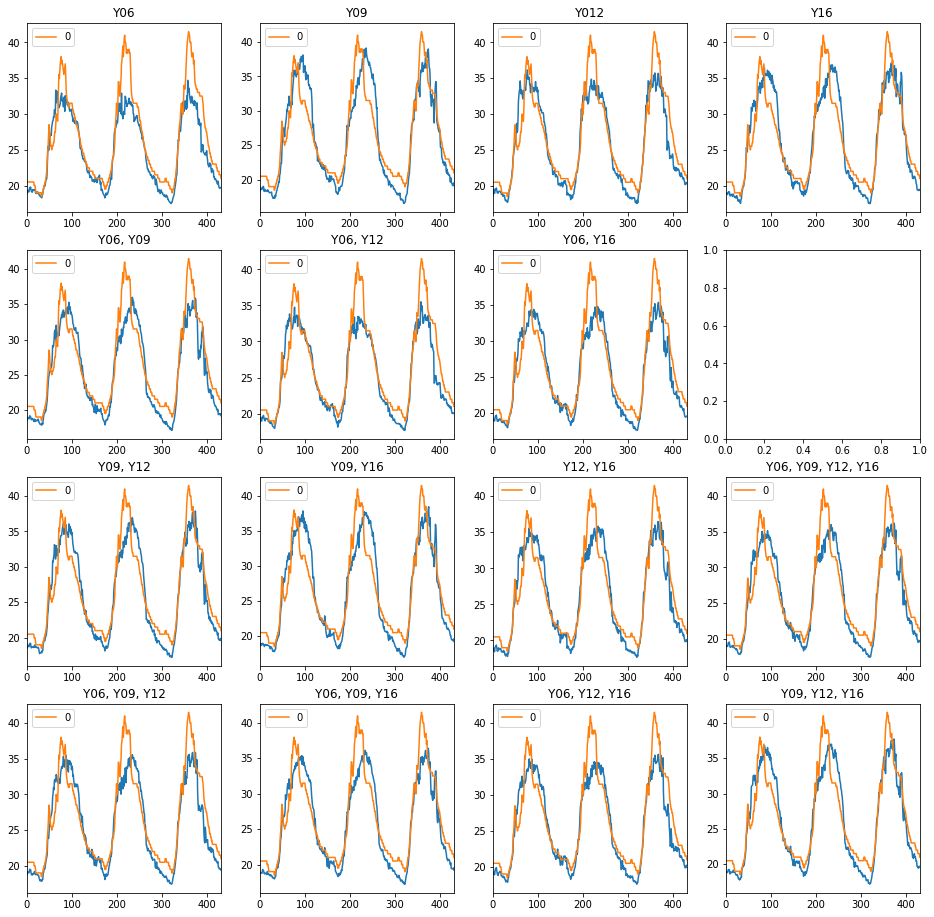

In [29]:
f, ax = make_figure(4,4)

result.iloc[:,0].plot(ax = ax[0][0])
ax[0][0].set_title('Y06')
Y.plot(ax = ax[0][0])

result.iloc[:,1].plot(ax = ax[0][1])
ax[0][1].set_title('Y09')
Y.plot(ax = ax[0][1])

result.iloc[:,2].plot(ax = ax[0][2])
ax[0][2].set_title('Y012')
Y.plot(ax = ax[0][2])

result.iloc[:,3].plot(ax = ax[0][3])
ax[0][3].set_title('Y16')
Y.plot(ax = ax[0][3])

result.iloc[:,4].plot(ax = ax[1][0])
ax[1][0].set_title('Y06, Y09')
Y.plot(ax = ax[1][0])

result.iloc[:,5].plot(ax = ax[1][1])
ax[1][1].set_title('Y06, Y12')
Y.plot(ax = ax[1][1])

result.iloc[:,6].plot(ax = ax[1][2])
ax[1][2].set_title('Y06, Y16')
Y.plot(ax = ax[1][2])

result.iloc[:,7].plot(ax = ax[2][0])
ax[2][0].set_title('Y09, Y12')
Y.plot(ax = ax[2][0])

result.iloc[:,8].plot(ax = ax[2][1])
ax[2][1].set_title('Y09, Y16')
Y.plot(ax = ax[2][1])

result.iloc[:,9].plot(ax = ax[2][2])
ax[2][2].set_title('Y12, Y16')
Y.plot(ax = ax[2][2])

result.iloc[:,-1].plot(ax = ax[2][3])
ax[2][3].set_title('Y06, Y09, Y12, Y16')
Y.plot(ax = ax[2][3])

result.iloc[:,10].plot(ax = ax[3][0])
ax[3][0].set_title('Y06, Y09, Y12')
Y.plot(ax = ax[3][0])

result.iloc[:,11].plot(ax = ax[3][1])
ax[3][1].set_title('Y06, Y09, Y16')
Y.plot(ax = ax[3][1])

result.iloc[:,12].plot(ax = ax[3][2])
ax[3][2].set_title('Y06, Y12, Y16')
Y.plot(ax = ax[3][2])

result.iloc[:,13].plot(ax = ax[3][3])
ax[3][3].set_title('Y09, Y12, Y16')
Y.plot(ax = ax[3][3])

In [0]:
compare_lst = []

for i in range(len(lst)):
  tmp_mse = np.array(Y.T) - np.array(result.iloc[:,i])
  compare_lst.append([result.columns[i], (tmp_mse**2).sum()])

In [32]:
pd.DataFrame(compare_lst).sort_values(by = 1)

,0,1
7,Y09 Y12,2606.919083
9,Y12 Y16,2628.469587
13,Y09 Y12 Y16,2634.558944
14,Y06 Y09 Y12 Y16,2702.002512
2,Y12,2712.463555
12,Y06 Y12 Y16,2815.491997
11,Y06 Y09 Y16,2826.684419
6,Y06 Y16,2919.481975
3,Y16,2941.091827
10,Y06 Y09 Y12,3001.492622


- 각각의 Y값을 예측한 후 평균의 값으로 할지
- 먼저 평균을 해 하나의 값으로 예측을 할지
<br>

- 반올림 한 값 vs 하지 않은 값

In [34]:
# 4300개의 예측값(12,16 평균) + Y_의 실제값
before = train_dt[lst[7]].iloc[:-432].mean(axis = 1)
# after = main[[18]].mean(axis = 1)

after = train_dt.iloc[4320:,-1]

Y_train = pd.concat([before, after],ignore_index=True)

Y_train

0        8.00
1        7.50
2        7.25
3        7.00
4        6.75
        ...  
4747    21.50
4748    21.50
4749    21.50
4750    21.50
4751    21.00
Length: 4752, dtype: float64

In [0]:
def predict_test(X_train, y_train, X_test):

  lgb_train = lgb.Dataset(X_train, label=y_train)

  lgb_param = {
      "objective":"regression",
      "metrics":"mae",
      "learning_rate":0.01
  }

  print("cv start")
  cv_result = lgb.cv(
      lgb_param,
      lgb_train,
      num_boost_round=99999,
      nfold=5,
      early_stopping_rounds=10,
      stratified=False,
      verbose_eval=10 
  )

  print("train start")
  lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result["l1-mean"])
  )

  pred = lgb_model.predict(X_test)

  return pred

In [69]:
X_train = train_dt.loc[:, 'X01':'X39']

y_pred = predict_test(X_train, Y_train, test_dt)

cv start
[10]	cv_agg's l1: 6.57071 + 0.0770941
[20]	cv_agg's l1: 5.97342 + 0.0713122
[30]	cv_agg's l1: 5.43478 + 0.0667492
[40]	cv_agg's l1: 4.94887 + 0.0638462
[50]	cv_agg's l1: 4.50875 + 0.0603961
[60]	cv_agg's l1: 4.1146 + 0.0576383
[70]	cv_agg's l1: 3.75887 + 0.0550907
[80]	cv_agg's l1: 3.43844 + 0.0532245
[90]	cv_agg's l1: 3.15073 + 0.0509763
[100]	cv_agg's l1: 2.89405 + 0.0476283
[110]	cv_agg's l1: 2.66538 + 0.0440946
[120]	cv_agg's l1: 2.46091 + 0.0409111
[130]	cv_agg's l1: 2.27902 + 0.0373228
[140]	cv_agg's l1: 2.11656 + 0.0327222
[150]	cv_agg's l1: 1.97185 + 0.0284895
[160]	cv_agg's l1: 1.84113 + 0.024447
[170]	cv_agg's l1: 1.72593 + 0.023593
[180]	cv_agg's l1: 1.62484 + 0.0227204
[190]	cv_agg's l1: 1.53414 + 0.0233066
[200]	cv_agg's l1: 1.45365 + 0.024042
[210]	cv_agg's l1: 1.38247 + 0.0234163
[220]	cv_agg's l1: 1.31739 + 0.0236056
[230]	cv_agg's l1: 1.25951 + 0.0242793
[240]	cv_agg's l1: 1.20817 + 0.0251337
[250]	cv_agg's l1: 1.16239 + 0.025823
[260]	cv_agg's l1: 1.12224 + 0

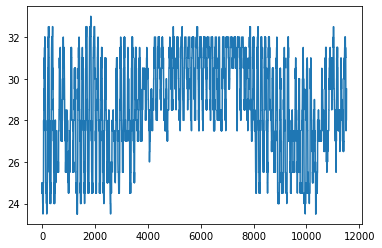

In [73]:
y_pred_result = ((y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

In [74]:
y_pred_result.head()

,Y18
id,
4752,24.5
4753,24.5
4754,24.5
4755,25.0
4756,24.5


In [0]:
y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')